# Poem Generator
___
The goal of this notebook is to generate new poems using a probabilistic model.


![poems](https://upload.wikimedia.org/wikipedia/commons/5/5b/Power-of-words-by-antonio-litterio-creative-commons-attribution-share-alike-3-0.jpg)

# Probabilistc model? Wut?

![wut cat](https://upload.wikimedia.org/wikipedia/commons/2/22/Lolwut_cat.jpg)

## Probability!

That's it! We are going to create a new sentence using the probability of every word appearing next to another. Take a look:

Using the dataset that we have, we can calculate the probability of any word occurring. Let's say that we have the corpus:

corpus = [ ['I like the weather'] , 
  ['the weather is nice'] ,
  ['I don't like the weather'] ]
  
  
 Using the corpus we can calculate the probability of each word appearing, considering the 7 different words from our corpus.
 <br>
 
|   Word  	| Frequency 	| Probability formula 	|    Result   	|
|:-------:	|:---------:	|:-------------------:	|:-----------:	|
|    I    	|     2     	|         2/7         	| 0,285714286 	|
|   like  	|     2     	|         2/7         	| 0,285714286 	|
|   the   	|     3     	|         3/7         	| 0,428571429 	|
| weather 	|     3     	|         3/7         	| 0,428571429 	|
|    is   	|     1     	|         1/7         	| 0,142857143 	|
|   nice  	|     1     	|         1/7         	| 0,142857143 	|
|  don't  	|     1     	|         1/7         	| 0,142857143 	|

<br>

So the probability of the word **' I '** occuring is 0,28, but what is the probabilty of **' I like '** occuring? To solve this we need to understand the chain rule of probability.

## Chain rule of probability

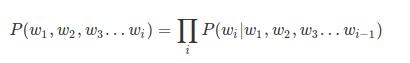

Super easy to understand right? If not let's break it down using our example.

p(i,like) = p(like) * p(i)

p(i,like) = 0,285714286 * 0,285714286

p(i,like) = 0,081632653

But what if we wanted to calculate something more meaningful, maybe 'I like the':

p(i,like,the) = p(the) * p(i,like)

p(i,like,the) = 0,428571429 * 0,081632653

p(i,like,the) = 0,034985423


## Generating Poems using MLE

Using the chain rule of probability we can calculate any probabilty of combination of words, from now on we're going to call the combination of words N-gram (where N is the number of words) i.e. 2-gram (bigram) is (i,like) and a 3-gram (trigram) is (i,like,the).

We can define the probability of a combination of word happening and the ratio between that phrase and n-1 of that phrase.

> p(i, like, the) = how many times ' i like the ' happened / how many time ' i like ' happened.

With this estimative we can find the probability of ' the ' being the next word after ' i like ' . If we do this for our whole dataset of poems we can generate a model that choose a word based on the probability distribution of the next word based on the two word before. Sound complicated I know, but let's try.

In [ ]:
## importing our libraries
import pandas as pd
import numpy as np

## we are goingo to use bigram and trigrams to separate our dataset in combinations of two and three words
from nltk.util import bigrams,trigrams

## we are going to use Counter to counter the bigrams and trigrams of our dataset.
from collections import Counter

## let's use regular expressions to treat our dataset
import re

## let's use random to choose the words of our poem based on a probability distribution
import random

In [ ]:
## reading the dataset
df = pd.read_csv('/kaggle/input/poems-in-portuguese/portuguese-poems.csv')

## droping any NA values from content (that's the columns where the content of the poem is written)
df.dropna(subset=['Content'],inplace=True)

## reseting the index
df.reset_index(drop=True,inplace=True)
df.shape

In [ ]:
## checking the distribution of authors

df.Author.value_counts(normalize=True)[:10].plot.bar();

Since more than 14% of our dataset is composed of Fernando Pessoa's poems our model will probably be biased to his style. 

In [ ]:
## let's generate our corpus

def generate_corpus(df):
    
    corpus = []
    
    for i in range(len(df)):
        s = df.Content[i].casefold().replace('\r\n', ' ').replace('\n',' ')
        s = re.sub('([.,!?():-])', r' \1 ', s)
        s = re.sub('\s{2,}', ' ', s).split(' ')
        corpus.append(s)
        
    return corpus

## creating the tags for our corpus

def create_tags(corpus):
    
    words = []
    
    for sentence in corpus:
        sentence.insert(0, '<s>')
        sentence.insert(0, '<s>')
        sentence.append('</s>')
        words.extend(sentence)
        
    return words

I've added some tags to mark the start and the end of each sentence. So we can calculate the probablity of the sentence starting with each word ... the initial bigram will be (' < s > ' , ' < s > ').

In [ ]:
## creating the corpus

corpus = generate_corpus(df)
print(corpus[0:2])

In [ ]:
## inserting the tags and gerenating a single string to divide our dataset in bigrams and trigrams

single_string = create_tags(corpus)
print(single_string[0:100])

In [ ]:
## creating the bigrams of each combination of word

words_bigram = bigrams(single_string)

In [ ]:
## creating the trigram of each combination of word

words_trigram = trigrams(single_string)

Now that we have bigrams and trigramns we have to count them.

In [ ]:
## counting bigrams

bigram_count = Counter(words_bigram)
bigram_count[('<s>', '<s>')]

In [ ]:
## counting trigrams

trigram_count = Counter(words_trigram)
trigram_count[('<s>', '<s>','eu')]

We have 15541 bigrams initiating with (' < s > ' , ' < s > '), that means we have 15541 poems! Since we've added these two markers in the begginning of each document. However analysing the trigram (' < s > ' , ' < s > ', ' eu ' ) we can see that of all the 15541 poems only 319 of them started with the word ' eu '.

In [ ]:
## creating a list of bigramns and trigrams so we can calculate the probilities

bigram_key = list(bigram_count.keys())
trigram_key = list(trigram_count.keys())

In [ ]:
list_bigram = []
list_lastword = []
list_probs = []

## for each trigram t

for t in trigram_key:
    
    ## create a bigram using the first two words of the trigram
    key_bigram = (t[0], t[1])
    
    ## find how many times the trigram happened and divide it by the number of times that the bigram happened
    prob = trigram_count[t] / bigram_count[key_bigram]
    
    ## append the lists above
    list_bigram.append(key_bigram)
    list_lastword.append(t[2])
    list_probs.append(prob)

In [ ]:
## creating a dataframe with the results

model_df = pd.DataFrame({'bigram': list_bigram, 'lastword': list_lastword, 'prob': list_probs})
model_df

Let's do some of it by hand!

In [ ]:
## how many time <s><s> appeared

bigram_count[('<s>', '<s>')]

In [ ]:
## how many time <s><s><eu> appeared

trigram_count[('<s>', '<s>','eu')]

In [ ]:
## probability of the word 'eu' appearing next to <s><s>

319 / 15541

In [ ]:
## taking the proof

model_df.iloc[0,:]

We can use the dataframe created to find all the possible words that come after (' < s > ' , ' < s > ').

In [ ]:
test_df = model_df.loc[model_df['bigram'] == ('<s>', '<s>')]
test_df.sort_values('prob',ascending=False)

The dataframe above means that the word ' a ' is the most probable to occour after (' < s > ' , ' < s > '). But what can occur after it? Just take a look at the dataframe below.

In [ ]:
test_df = model_df.loc[model_df['bigram'] == ('<s>', 'a')]
test_df.sort_values('prob',ascending=False)

## Generating the poems

Now we can use the distribution of all the probabilities in model_df to choose what will be the last word given a bigram. We're not going to use only the word with the highest probability but the probability of each one using random.choices.

In [ ]:
num_sents = 2
current_bigram = ('<s>', '<s>')
i = 0
while i < num_sents:
    df = model_df.loc[model_df['bigram'] == current_bigram]
    words = df['lastword'].values
    probs = df['prob'].values
    last_word = random.choices(words, probs)[0]
    
    current_bigram = (current_bigram[1], last_word)
    
    if last_word == '</s>':
        i+=1
    
    if last_word != '<s>' and last_word != '</s>':
        print(last_word, end=' ')

It's simple! We can even go further by querying at the beggining only the name of one particular author. I hope you've learned something here, any doubts please comment and leave a like if you actually like the work.